In [1]:
from snorkel.labeling.apply.dask import PandasParallelLFApplier
from snorkel.labeling.model.label_model import LabelModel
from snorkel.labeling import labeling_function, LFAnalysis
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matrixprofile import matrixProfile
from datetime import datetime, timedelta
from tqdm import tqdm
import pandas as pd
import numpy as np
import time

In [2]:
tqdm.pandas()

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.min_rows', None)

In [4]:
# Label mappings

ABSTAIN = -1
NOT_SUPPRESSIBLE = 0
SUPPRESSIBLE = 1

In [5]:
# Read in data

alarms_df = pd.read_pickle('chop_spo2alarms_df.pkl')
#vitals_df = pd.read_pickle('chop_vitals_df.pkl')
vitals_df = pd.read_pickle('chop_vitals_with_mp_df.pkl')

In [6]:
INTERVAL = 5

In [7]:
# Set age factors for labeling functions

age_factors_df = pd.DataFrame({'pt_age_group':[1,2,3,4], 
                                'pt_age_group_L':['< 1 month','1-< 2 month','2-< 6 month','6 months and older'], 
                                'hr_age_factor':[3.833, 3.766, 3.733, 3.533], 
                                'rr_age_factor':[0.933, 0.9, 0.866, 0.8]}, 
                                index=[1,2,3,4])

In [ ]:
# Matrix profile related functions

np.seterr(divide='ignore', invalid='ignore')

def compute_std(ts, window):
    """
    Compute moving std
    
    Args:
        ts - time series data
        window - window (subsequence) length
    
    Return:
        float - moving std
    """
    ts_std = []
    for i in range(len(ts) - window):
        ts_std.append(np.std(ts[i: i+window-1]))
    ts_std = np.array(ts_std)
    ts_std_head = np.zeros(window // 2 - 1)
    ts_std_tail = np.zeros(len(ts) - len(ts_std) - window // 2 + 1)
    ts_std = np.concatenate([ts_std_head, ts_std, ts_std_tail])
    return ts_std


def compute_mp(ts, window, threshold=None):
    """
    Compute matrix profile at given window
    
    Args:
        ts - array containing time series data
        window - window length
        threshold - threshold for outlier value
    
    Return:
        numpy array - matrix profile
    """
    # sfp - commenting this out as it is unneccesary
    # remove trailing nans of ts
    #i = len(ts) - 1
    #while np.isnan(ts[i]) and i >= 0:
    #    i -= 1
    #ts = ts[0:i+1]
    
    # compute mp by stamp
    mp = np.array(matrixProfile.stomp(ts, m=window))[0]
    
    # calibrate ts and mp, so mp value is assigned to the middle of that window
    mp_head = np.zeros(window//2 - 1)
    mp_tail = np.zeros(len(ts) - len(mp) - window//2 + 1)
    mp = np.concatenate([mp_head, mp, mp_tail])
    
    # remove error results due to zero std (make them 0 so they don't contribute to outliers)
    ts_std = compute_std(ts, window=window)
    count_zero_std = 0
    for i in range(len(ts_std)):
        if ts_std[i] == 0:
            mp[i] = 0
            count_zero_std += 1

    # compute percentage of outliers, where head, tail and zero std points do not participate
    if not threshold is None:
        outlier = mp[np.where(mp > threshold)]
        outlier_percentage = len(outlier) / (len(mp) - len(mp_head) - len(mp_tail) - count_zero_std)
        print('outlier %: ' + str(outlier_percentage))
        #return mp, outlier_percentage
    
    return mp


def apply_compute_mp(df, verbose=True, save=False):
    """
    Compute a matrix profile per patient with window sizes 20 to 120 seconds
    
    Args:
        verbose - True to print function time duration, otherwise False
        
    Return:
        dataframe - copy of vitals dataframe with new matrix profile columns
                    for SPO2, heart rate, and respiratory rate
    """
    start_time = time.time()
    
    new_df = df.copy()
    
    for vital in ['SPO2-%','HR','RESP']:
        for w in range(20,130,10):
            mps = df.groupby('pt_id')[vital].progress_apply(lambda x: compute_mp(x.to_numpy(), w//INTERVAL))
            mps = mps.reindex(df.index.get_level_values(0).drop_duplicates())
            new_df[vital + ' MP' + str(w)] = mps.explode().to_numpy()

            # correctness check for 'apply_compute_mp'
            #for pt in new_df.index.levels[0]:
            #    if not np.all(new_df.loc[(pt, ), vital + ' MP' + str(w)].to_numpy() == mps[pt]):
            #        print('Non-match on patient ' + str(pt))
            
    if save:
        new_df.to_pickle('chop_vitals_with_mp_df.pkl')
    
    if verbose:
        print(time.time() - start_time)
        
    return new_df


#new_vitals_df = apply_compute_mp(vitals_df, save=True)

In [23]:
# Labeling functions for Snorkel

def get_vitals(pt_id, v_sign):
    """
    Get timeseries of a specific vital sign for a given patient
    
    Args:
        pt_id - integer id of patient
        v_sign - string vital sign name
        
    Return:
        timeseries array of vital sign for patient
    """
    return vitals_df.loc[(pt_id, ), v_sign]


@labeling_function()
def lf_long_alarm_60s(x):
    """
    If the alarm duration is at least 60 seconds then the alarm is not suppressible, 
    otherwise abstain 
    """
    return NOT_SUPPRESSIBLE if x.duration >= 60 else ABSTAIN


@labeling_function()
def lf_long_alarm_65s(x):
    """
    If the alarm duration is at least 65 seconds then the alarm is not suppressible, 
    otherwise abstain 
    """
    return NOT_SUPPRESSIBLE if x.duration >= 65 else ABSTAIN


@labeling_function()
def lf_long_alarm_70s(x):
    """
    If the alarm duration is at least 70 seconds then the alarm is not suppressible, 
    otherwise abstain 
    """
    return NOT_SUPPRESSIBLE if x.duration >= 70 else ABSTAIN


@labeling_function()
def lf_spo2_below85_over120s(x):
    """
    If SpO2 level stays within range (80,85] for longer than 120 seconds since alarm start 
    then the alarm is not suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 'SPO2-%')
    spo2 = spo2[x.alarm_datetime:(x.alarm_datetime + timedelta(seconds=121))]
    return NOT_SUPPRESSIBLE if np.all( (80 < spo2) & (spo2 <= 85) ) else ABSTAIN


@labeling_function()
def lf_spo2_below80_over100s(x):
    """
    If SpO2 level stays within range (70,80] for longer than 100 seconds since alarm start 
    then the alarm is not suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 'SPO2-%')
    spo2 = spo2[x.alarm_datetime:(x.alarm_datetime + timedelta(seconds=101))]
    return NOT_SUPPRESSIBLE if np.all( (70 < spo2) & (spo2 <= 80) ) else ABSTAIN


@labeling_function()
def lf_spo2_below70_over90s(x):
    """
    If SpO2 level stays within range (60,70] for longer than 90 seconds since alarm start 
    then the alarm is not suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 'SPO2-%')
    spo2 = spo2[x.alarm_datetime:(x.alarm_datetime + timedelta(seconds=91))]
    return NOT_SUPPRESSIBLE if np.all( (60 < spo2) & (spo2 <= 70) ) else ABSTAIN


@labeling_function()
def lf_spo2_below60_over60s(x):
    """
    If SpO2 level stays within range (50,60] for longer than 60 seconds since alarm start 
    then the alarm is not suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 'SPO2-%')
    spo2 = spo2[x.alarm_datetime:(x.alarm_datetime + timedelta(seconds=61))]
    return NOT_SUPPRESSIBLE if np.all( (50 < spo2) & (spo2 <= 60) ) else ABSTAIN


@labeling_function()
def lf_spo2_below50_over30s(x):
    """
    If SpO2 level stays within range (0,50] for longer than 30 seconds since alarm start 
    then the alarm is not suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 'SPO2-%')
    spo2 = spo2[x.alarm_datetime:(x.alarm_datetime + timedelta(seconds=31))]
    return NOT_SUPPRESSIBLE if np.all( spo2 <= 50 ) else ABSTAIN
    

@labeling_function()
def lf_hr_below50_over120s(x):
    """
    If HR below 50 * age factor for over 120 seconds since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    hr = get_vitals(x.pt_id, 'HR')
    hr = hr[x.alarm_datetime:(x.alarm_datetime + timedelta(seconds=121))]
    age_factor = age_factors_df.loc[x.pt_age_group, 'hr_age_factor']
    return NOT_SUPPRESSIBLE if np.all( (40*age_factor < hr) & (hr <= 50*age_factor) ) else ABSTAIN
    
    
@labeling_function()
def lf_hr_below40_over60s(x):
    """
    If HR below 40 * age factor for over 60 seconds since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    hr = get_vitals(x.pt_id, 'HR')
    hr = hr[x.alarm_datetime:(x.alarm_datetime + timedelta(seconds=61))]
    age_factor = age_factors_df.loc[x.pt_age_group, 'hr_age_factor']
    return NOT_SUPPRESSIBLE if np.all( (30*age_factor < hr) & (hr <= 40*age_factor) ) else ABSTAIN


@labeling_function()
def lf_hr_below30(x):
    """
    If HR below 30 * age factor for any duration since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    hr = get_vitals(x.pt_id, 'HR')
    hr = hr[x.alarm_datetime:(x.alarm_datetime + timedelta(seconds=int(x.duration)))]
    age_factor = age_factors_df.loc[x.pt_age_group, 'hr_age_factor']
    return NOT_SUPPRESSIBLE if np.all( hr <= 30*age_factor ) else ABSTAIN


@labeling_function()
def lf_rr_below50_over120s(x):
    """
    If RR below 50 * age factor for over 120 seconds since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    rr = get_vitals(x.pt_id, 'RESP')
    rr = rr[x.alarm_datetime:(x.alarm_datetime + timedelta(seconds=121))]
    age_factor = age_factors_df.loc[x.pt_age_group, 'rr_age_factor']
    return NOT_SUPPRESSIBLE if np.all( (40*age_factor < rr) & (rr <= 50*age_factor) ) else ABSTAIN


@labeling_function()
def lf_rr_below40_over60s(x):
    """
    If RR below 40 * age factor for over 60 seconds since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    rr = get_vitals(x.pt_id, 'RESP')
    rr = rr[x.alarm_datetime:(x.alarm_datetime + timedelta(seconds=61))]
    age_factor = age_factors_df.loc[x.pt_age_group, 'rr_age_factor']
    return NOT_SUPPRESSIBLE if np.all( (30*age_factor < rr) & (rr <= 40*age_factor) ) else ABSTAIN


@labeling_function()
def lf_rr_below30(x):
    """
    If RR below 30 * age factor for any duration since alarm start then the alarm is not suppressible, 
    otherwise abstain
    """
    rr = get_vitals(x.pt_id, 'RESP')
    rr = rr[x.alarm_datetime:(x.alarm_datetime + timedelta(seconds=int(x.duration)))]
    age_factor = age_factors_df.loc[x.pt_age_group, 'rr_age_factor']
    return NOT_SUPPRESSIBLE if np.all( rr <= 30*age_factor ) else ABSTAIN


@labeling_function()
def lf_gradual_recovery(x):
    """
    If SpO2 increases at 5-10% per minute after the alarm then the alarm is not suppressible,
    otherwise abstain
    """
    return ABSTAIN
    
    
def repeat_alarms(x, t):
    """
    If there exists other SpO2 alarms 't' minutes prior to the current alarm's start time and/or
    if there exists other SpO2 alarms 't' minutes after the current alarm's end time then
    the alarm is not suppressible, otherwise abstain

    Args:
        x - alarm instance
        t - timespan to consider (in seconds)
    """
    prior_alarms = alarms_df[ (alarms_df['pt_id'] == x.pt_id) & \
                                (x.alarm_datetime - timedelta(seconds=t) <= alarms_df['alarm_datetime']) & \
                                (alarms_df['alarm_datetime'] < x.alarm_datetime) ]

    subsq_alarms = alarms_df[ (alarms_df['pt_id'] == x.pt_id) & \
                                (x.alarm_datetime + timedelta(seconds=int(x.duration)) <= alarms_df['alarm_datetime']) & \
                                (alarms_df['alarm_datetime'] <= x.alarm_datetime + timedelta(seconds=int(x.duration + t))) ]
    
    count = prior_alarms.shape[0] + subsq_alarms.shape[0]
    
    return NOT_SUPPRESSIBLE if count > 0 else ABSTAIN


@labeling_function()
def lf_repeat_alarms_15s(x):
    """
    If there exists other alarms within 15 seconds of the current alarm then the alarm is
    not suppressible, otherwise abstain
    """
    return repeat_alarms(x, 15) 


@labeling_function()
def lf_repeat_alarms_30s(x):
    """
    If there exists other alarms within 30 seconds of the current alarm then the alarm is
    not suppressible, otherwise abstain
    """
    return repeat_alarms(x, 30) 


@labeling_function()
def lf_repeat_alarms_60s(x):
    """
    If there exists other alarms within 60 seconds of the current alarm then the alarm is
    not suppressible, otherwise abstain
    """
    return repeat_alarms(x, 60)


@labeling_function()
def lf_short_alarm_15s(x):
    """
    If the SpO2-Low alarm duration is at most 15 seconds then the alarm is suppressible, 
    otherwise abstain 
    """
    return SUPPRESSIBLE if x.duration <= 15 else ABSTAIN


@labeling_function()
def lf_short_alarm_10s(x):
    """
    If the SpO2-Low alarm duration is at most 10 seconds then the alarm is suppressible, 
    otherwise abstain 
    """
    return SUPPRESSIBLE if x.duration <= 10 else ABSTAIN


@labeling_function()
def lf_short_alarm_5s(x):
    """
    If the SpO2-Low alarm duration is at most 5 seconds then the alarm is suppressible, 
    otherwise abstain 
    """
    return SUPPRESSIBLE if x.duration <= 5 else ABSTAIN


def max_recovery(data):
    """
    Determine the maximum recovery between two consecutive data points in given data
    
    Args:
        data - array of numeric measurements
        
    Return:
        float - maximum recovery
    """
    r = []
    
    for i in range(len(data)):
        for j in range(i+1, len(data)):
            r.append(data[j] - data[i])
            
    return max(r)


@labeling_function()
def lf_immediate_recovery_10s(x):
    """
    If SpO2 level increases/recovers by more than 20 percentage points within 
    10 seconds of alarm start then the alarm is suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 'SPO2-%')
    return SUPPRESSIBLE if max_recovery(spo2[x.alarm_datetime:(x.alarm_datetime + timedelta(seconds=10))]) > 20 else ABSTAIN


@labeling_function()
def lf_immediate_recovery_15s(x):
    """
    If SpO2 level increases/recovers by more than 30 percentage points within 
    15 seconds of alarm start then the alarm is suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 'SPO2-%')
    return SUPPRESSIBLE if max_recovery(spo2[x.alarm_datetime:(x.alarm_datetime + timedelta(seconds=15))]) > 30 else ABSTAIN


@labeling_function()
def lf_hr_tech_err_20(x):
    """
    If the difference between the SpO2 HR and ECG HR is larger than 20 percentage points 
    at time of alarm then suppressible, otherwise abstain
    """
    spo2_hr = get_vitals(x.pt_id, 'SPO2-R')
    ecg_hr = get_vitals(x.pt_id, 'HR')
    return SUPPRESSIBLE if abs(spo2_hr[x.alarm_datetime] - ecg_hr[x.alarm_datetime]) > 20 else ABSTAIN


@labeling_function()
def lf_hr_tech_err_30(x):
    """
    If the difference between the SpO2 HR and ECG HR is larger than 30 percentage points 
    at time of alarm then suppressible, otherwise abstain
    """
    spo2_hr = get_vitals(x.pt_id, 'SPO2-R')
    ecg_hr = get_vitals(x.pt_id, 'HR')
    return SUPPRESSIBLE if abs(spo2_hr[x.alarm_datetime] - ecg_hr[x.alarm_datetime]) > 30 else ABSTAIN


@labeling_function()
def lf_outlier_spo2_120(x):
    """
    If there exists an outlier (spike in matrix profile larger than 8.4) in the 
    120 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 'SPO2-% MP120')
    spo2 = spo2[(x.alarm_datetime - timedelta(seconds=60)):(x.alarm_datetime + timedelta(seconds=60))]
    return SUPPRESSIBLE if np.any( spo2 > 8.4 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_110(x):
    """
    If there exists an outlier (spike in matrix profile larger than 7.8) in the 
    110 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 'SPO2-% MP110')
    spo2 = spo2[(x.alarm_datetime - timedelta(seconds=55)):(x.alarm_datetime + timedelta(seconds=55))]
    return SUPPRESSIBLE if np.any( spo2 > 7.8 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_100(x):
    """
    If there exists an outlier (spike in matrix profile larger than 7.2) in the 
    100 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 'SPO2-% MP100')
    spo2 = spo2[(x.alarm_datetime - timedelta(seconds=50)):(x.alarm_datetime + timedelta(seconds=50))]
    return SUPPRESSIBLE if np.any( spo2 > 7.2 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_90(x):
    """
    If there exists an outlier (spike in matrix profile larger than 6.6) in the 
    90 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 'SPO2-% MP90')
    spo2 = spo2[(x.alarm_datetime - timedelta(seconds=45)):(x.alarm_datetime + timedelta(seconds=45))]
    return SUPPRESSIBLE if np.any( spo2 > 6.6 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_80(x):
    """
    If there exists an outlier (spike in matrix profile larger than 6.0) in the 
    80 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 'SPO2-% MP80')
    spo2 = spo2[(x.alarm_datetime - timedelta(seconds=40)):(x.alarm_datetime + timedelta(seconds=40))]
    return SUPPRESSIBLE if np.any( spo2 > 6.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_70(x):
    """
    If there exists an outlier (spike in matrix profile larger than 5.3) in the 
    70 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 'SPO2-% MP70')
    spo2 = spo2[(x.alarm_datetime - timedelta(seconds=35)):(x.alarm_datetime + timedelta(seconds=35))]
    return SUPPRESSIBLE if np.any( spo2 > 5.3 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_60(x):
    """
    If there exists an outlier (spike in matrix profile larger than 4.6) in the 
    60 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 'SPO2-% MP60')
    spo2 = spo2[(x.alarm_datetime - timedelta(seconds=30)):(x.alarm_datetime + timedelta(seconds=30))]
    return SUPPRESSIBLE if np.any( spo2 > 4.6 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_50(x):
    """
    If there exists an outlier (spike in matrix profile larger than 3.8) in the 
    50 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 'SPO2-% MP50')
    spo2 = spo2[(x.alarm_datetime - timedelta(seconds=25)):(x.alarm_datetime + timedelta(seconds=25))]
    return SUPPRESSIBLE if np.any( spo2 > 3.8 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_40(x):
    """
    If there exists an outlier (spike in matrix profile larger than 2.9) in the 
    40 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 'SPO2-% MP40')
    spo2 = spo2[(x.alarm_datetime - timedelta(seconds=20)):(x.alarm_datetime + timedelta(seconds=20))]
    return SUPPRESSIBLE if np.any( spo2 > 2.9 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_30(x):
    """
    If there exists an outlier (spike in matrix profile larger than 2.1) in the 
    30 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 'SPO2-% MP30')
    spo2 = spo2[(x.alarm_datetime - timedelta(seconds=15)):(x.alarm_datetime + timedelta(seconds=15))]
    return SUPPRESSIBLE if np.any( spo2 > 2.1 ) else ABSTAIN


@labeling_function()
def lf_outlier_spo2_20(x):
    """
    If there exists an outlier (spike in matrix profile larger than 1.0) in the 
    20 second window surrounding the time of alarm then suppressible, otherwise abstain
    """
    spo2 = get_vitals(x.pt_id, 'SPO2-% MP20')
    spo2 = spo2[(x.alarm_datetime - timedelta(seconds=10)):(x.alarm_datetime + timedelta(seconds=10))]
    return SUPPRESSIBLE if np.any( spo2 > 1.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_120(x):
    """
    If there exists at least one data point where the 120-second window heart rate matrix profile
    exceeds 9.0 within a 120-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 'HR MP120')
    hr_mp = hr_mp[(x.alarm_datetime - timedelta(seconds=60)):(x.alarm_datetime + timedelta(seconds=60))]
    return SUPPRESSIBLE if np.any( hr_mp > 9.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_110(x):
    """
    If there exists at least one data point where the 110-second window heart rate matrix profile
    exceeds 8.5 within a 110-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 'HR MP110')
    hr_mp = hr_mp[(x.alarm_datetime - timedelta(seconds=55)):(x.alarm_datetime + timedelta(seconds=55))]
    return SUPPRESSIBLE if np.any( hr_mp > 8.5 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_100(x):
    """
    If there exists at least one data point where the 100-second window heart rate matrix profile
    exceeds 7.8 within a 100-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 'HR MP100')
    hr_mp = hr_mp[(x.alarm_datetime - timedelta(seconds=50)):(x.alarm_datetime + timedelta(seconds=50))]
    return SUPPRESSIBLE if np.any( hr_mp > 7.8 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_90(x):
    """
    If there exists at least one data point where the 90-second window heart rate matrix profile
    exceeds 7.3 within a 90-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 'HR MP90')
    hr_mp = hr_mp[(x.alarm_datetime - timedelta(seconds=45)):(x.alarm_datetime + timedelta(seconds=45))]
    return SUPPRESSIBLE if np.any( hr_mp > 7.3 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_80(x):
    """
    If there exists at least one data point where the 80-second window heart rate matrix profile
    exceeds 6.7 within a 80-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 'HR MP80')
    hr_mp = hr_mp[(x.alarm_datetime - timedelta(seconds=40)):(x.alarm_datetime + timedelta(seconds=40))]
    return SUPPRESSIBLE if np.any( hr_mp > 6.7 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_70(x):
    """
    If there exists at least one data point where the 70-second window heart rate matrix profile
    exceeds 6.0 within a 70-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 'HR MP70')
    hr_mp = hr_mp[(x.alarm_datetime - timedelta(seconds=35)):(x.alarm_datetime + timedelta(seconds=35))]
    return SUPPRESSIBLE if np.any( hr_mp > 6.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_60(x):
    """
    If there exists at least one data point where the 60-second window heart rate matrix profile
    exceeds 5.4 within a 60-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 'HR MP60')
    hr_mp = hr_mp[(x.alarm_datetime - timedelta(seconds=30)):(x.alarm_datetime + timedelta(seconds=30))]
    return SUPPRESSIBLE if np.any( hr_mp > 5.4 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_50(x):
    """
    If there exists at least one data point where the 50-second window heart rate matrix profile
    exceeds 4.7 within a 50-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 'HR MP50')
    hr_mp = hr_mp[(x.alarm_datetime - timedelta(seconds=25)):(x.alarm_datetime + timedelta(seconds=25))]
    return SUPPRESSIBLE if np.any( hr_mp > 4.7 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_40(x):
    """
    If there exists at least one data point where the 40-second window heart rate matrix profile
    exceeds 3.9 within a 40-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 'HR MP40')
    hr_mp = hr_mp[(x.alarm_datetime - timedelta(seconds=20)):(x.alarm_datetime + timedelta(seconds=20))]
    return SUPPRESSIBLE if np.any( hr_mp > 3.9 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_30(x):
    """
    If there exists at least one data point where the 30-second window heart rate matrix profile
    exceeds 3.1 within a 30-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 'HR MP30')
    hr_mp = hr_mp[(x.alarm_datetime - timedelta(seconds=15)):(x.alarm_datetime + timedelta(seconds=15))]
    return SUPPRESSIBLE if np.any( hr_mp > 3.1 ) else ABSTAIN


@labeling_function()
def lf_outlier_hr_20(x):
    """
    If there exists at least one data point where the 20-second window heart rate matrix profile
    exceeds 2.1 within a 20-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    hr_mp = get_vitals(x.pt_id, 'HR MP20')
    hr_mp = hr_mp[(x.alarm_datetime - timedelta(seconds=10)):(x.alarm_datetime + timedelta(seconds=10))]
    return SUPPRESSIBLE if np.any( hr_mp > 2.1 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_120(x):
    """
    If there exists at least one data point where the 120-second window respiratory rate matrix profile
    exceeds 8.7 within a 120-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 'RESP MP120')
    rr_mp = rr_mp[(x.alarm_datetime - timedelta(seconds=60)):(x.alarm_datetime + timedelta(seconds=60))]
    return SUPPRESSIBLE if np.any( rr_mp > 8.7 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_110(x):
    """
    If there exists at least one data point where the 110-second window respiratory rate matrix profile
    exceeds 8.1 within a 110-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 'RESP MP110')
    rrr_mp = rr_mp[(x.alarm_datetime - timedelta(seconds=55)):(x.alarm_datetime + timedelta(seconds=55))]
    return SUPPRESSIBLE if np.any( rr_mp > 8.1 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_100(x):
    """
    If there exists at least one data point where the 100-second window respiratory rate matrix profile
    exceeds 7.6 within a 100-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 'RESP MP100')
    rr_mp = rr_mp[(x.alarm_datetime - timedelta(seconds=50)):(x.alarm_datetime + timedelta(seconds=50))]
    return SUPPRESSIBLE if np.any( rr_mp > 7.6 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_90(x):
    """
    If there exists at least one data point where the 90-second window respiratory rate matrix profile
    exceeds 7.1 within a 90-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 'RESP MP90')
    rr_mp = rr_mp[(x.alarm_datetime - timedelta(seconds=45)):(x.alarm_datetime + timedelta(seconds=45))]
    return SUPPRESSIBLE if np.any( rr_mp > 7.1 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_80(x):
    """
    If there exists at least one data point where the 80-second window respiratory rate matrix profile
    exceeds 6.5 within a 80-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 'RESP MP80')
    rr_mp = rr_mp[(x.alarm_datetime - timedelta(seconds=40)):(x.alarm_datetime + timedelta(seconds=40))]
    return SUPPRESSIBLE if np.any( rr_mp > 6.5 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_70(x):
    """
    If there exists at least one data point where the 70-second window respiratory rate matrix profile
    exceeds 6.0 within a 70-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 'RESP MP70')
    rr_mp = rr_mp[(x.alarm_datetime - timedelta(seconds=35)):(x.alarm_datetime + timedelta(seconds=35))]
    return SUPPRESSIBLE if np.any( rr_mp > 6.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_60(x):
    """
    If there exists at least one data point where the 60-second window respiratory rate matrix profile
    exceeds 5.4 within a 60-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 'RESP MP60')
    rr_mp = rr_mp[(x.alarm_datetime - timedelta(seconds=30)):(x.alarm_datetime + timedelta(seconds=30))]
    return SUPPRESSIBLE if np.any( rr_mp > 5.4 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_50(x):
    """
    If there exists at least one data point where the 50-second window respiratory rate matrix profile
    exceeds 4.7 within a 50-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 'RESP MP50')
    rr_mp = rr_mp[(x.alarm_datetime - timedelta(seconds=25)):(x.alarm_datetime + timedelta(seconds=25))]
    return SUPPRESSIBLE if np.any( rr_mp > 4.7 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_40(x):
    """
    If there exists at least one data point where the 40-second window respiratory rate matrix profile
    exceeds 3.9 within a 40-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 'RESP MP40')
    rr_mp = rr_mp[(x.alarm_datetime - timedelta(seconds=20)):(x.alarm_datetime + timedelta(seconds=20))]
    return SUPPRESSIBLE if np.any( rr_mp > 3.9 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_30(x):
    """
    If there exists at least one data point where the 30-second window respiratory rate matrix profile
    exceeds 3.0 within a 30-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 'RESP MP30')
    rr_mp = rr_mp[(x.alarm_datetime - timedelta(seconds=15)):(x.alarm_datetime + timedelta(seconds=15))]
    return SUPPRESSIBLE if np.any( rr_mp > 3.0 ) else ABSTAIN


@labeling_function()
def lf_outlier_rr_20(x):
    """
    If there exists at least one data point where the 20-second window respiratory rate matrix profile
    exceeds 2.0 within a 20-second window surrounding the alarm then the alarm is suppressible, 
    otherwise abstain
    """
    rr_mp = get_vitals(x.pt_id, 'RESP MP20')
    rr_mp = rr_mp[(x.alarm_datetime - timedelta(seconds=10)):(x.alarm_datetime + timedelta(seconds=10))]
    return SUPPRESSIBLE if np.any( rr_mp > 2.0 ) else ABSTAIN

In [24]:
# Define set of LFs to use in the model

lfs = [
        lf_long_alarm_60s, lf_long_alarm_65s, lf_long_alarm_70s,
        lf_spo2_below85_over120s, lf_spo2_below80_over100s, lf_spo2_below70_over90s, lf_spo2_below60_over60s, lf_spo2_below50_over30s,
        lf_hr_below50_over120s, lf_hr_below40_over60s, lf_hr_below30,
        lf_rr_below50_over120s, lf_rr_below40_over60s, lf_rr_below30,
        lf_repeat_alarms_15s, lf_repeat_alarms_30s, lf_repeat_alarms_60s,
        lf_short_alarm_15s, lf_short_alarm_10s, lf_short_alarm_5s,
        lf_immediate_recovery_10s, lf_immediate_recovery_15s,
        lf_hr_tech_err_20, lf_hr_tech_err_30,
        lf_outlier_spo2_120, lf_outlier_spo2_110, lf_outlier_spo2_100, lf_outlier_spo2_90, lf_outlier_spo2_80, lf_outlier_spo2_70, lf_outlier_spo2_60, lf_outlier_spo2_50, lf_outlier_spo2_40, lf_outlier_spo2_30, lf_outlier_spo2_20,
        lf_outlier_hr_120, lf_outlier_hr_110, lf_outlier_hr_100, lf_outlier_hr_90, lf_outlier_hr_80, lf_outlier_hr_70, lf_outlier_hr_60, lf_outlier_hr_50, lf_outlier_hr_40, lf_outlier_hr_30, lf_outlier_hr_20,
        lf_outlier_rr_120, lf_outlier_rr_110, lf_outlier_rr_100, lf_outlier_rr_90, lf_outlier_rr_80, lf_outlier_rr_70, lf_outlier_rr_60, lf_outlier_rr_50, lf_outlier_rr_40, lf_outlier_rr_30, lf_outlier_rr_20
    ]

In [25]:
# LF application

applier = PandasParallelLFApplier(lfs)
L_train = applier.apply(alarms_df, n_parallel=10, scheduler='threads', fault_tolerant=True)

/home/sfpugh/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/home/sfpugh/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [26]:
# Fit a Label Model

l_model = LabelModel(cardinality=2)
l_model.fit(L_train)

In [27]:
print(LFAnalysis(L_train, lfs).lf_summary(Y=alarms_df.true_label.to_numpy(), est_weights=l_model.get_weights()))

/home/sfpugh/.local/lib/python3.6/site-packages/snorkel/labeling/model/label_model.py:378: RuntimeWarning: divide by zero encountered in true_divide
  return np.clip(accs / self.coverage, 1e-6, 1.0)


                            j Polarity  Coverage  Overlaps  Conflicts  \
lf_long_alarm_60s           0      [0]  0.055436  0.053599   0.017152   
lf_long_alarm_65s           1      [0]  0.046554  0.046554   0.015314   
lf_long_alarm_70s           2      [0]  0.041654  0.041654   0.014089   
lf_spo2_below85_over120s    3      [0]  0.048392  0.048392   0.030934   
lf_spo2_below80_over100s    4      [0]  0.050842  0.050842   0.032772   
lf_spo2_below70_over90s     5      [0]  0.050230  0.050230   0.032466   
lf_spo2_below60_over60s     6      [0]  0.050230  0.050230   0.032466   
lf_spo2_below50_over30s     7      [0]  0.055130  0.055130   0.036447   
lf_hr_below50_over120s      8      [0]  0.131700  0.124043   0.085452   
lf_hr_below40_over60s       9      [0]  0.153752  0.149770   0.119755   
lf_hr_below30              10      [0]  0.130475  0.130475   0.111485   
lf_rr_below50_over120s     11      [0]  0.048392  0.048392   0.030934   
lf_rr_below40_over60s      12      [0]  0.050536  0

In [46]:
# Predict labels with new model

y_pred, y_proba = l_model.predict(L_train, return_probs=True)

print('Confusion Matrix (original): ')
print(confusion_matrix(alarms_df.true_label, y_pred))

Confusion Matrix (original): 
[[   0    0    0]
 [  11  518   79]
 [ 145 1627  885]]


In [30]:
def predict_threshold(p, thres):
    """
    Predict alarm is SUPPRESSIBLE iff probability of suppressible is larger 
    than given threshold and is larger than probability of not-suppressible

    Args:
        p - array [P(NOT_SUPPRESSIBLE), P(SUPPRESSIBLE)]
        thres - threshold for SUPPRESSIBLE prediction

    Return:
        int - 1 if suppressible, 0 if not-suppressible, -1 if abstain
    """
    if p[SUPPRESSIBLE] > p[NOT_SUPPRESSIBLE] and p[SUPPRESSIBLE] >= thres:
        return SUPPRESSIBLE
    elif p[NOT_SUPPRESSIBLE] > p[SUPPRESSIBLE]:
        return NOT_SUPPRESSIBLE
    else:
        return ABSTAIN

Confusion Matrix (threshold=0.6):
[[   0    0    0]
 [  12  518   78]
 [ 155 1627  875]]
Confusion Matrix (threshold=0.7):
[[   0    0    0]
 [  13  518   77]
 [ 171 1627  859]]
Confusion Matrix (threshold=0.8):
[[   0    0    0]
 [  13  518   77]
 [ 182 1627  848]]
Confusion Matrix (threshold=0.9):
[[   0    0    0]
 [  15  518   75]
 [ 202 1627  828]]
Confusion Matrix (threshold=0.95):
[[   0    0    0]
 [  18  518   72]
 [ 230 1627  800]]
Confusion Matrix (threshold=0.99):
[[   0    0    0]
 [  18  518   72]
 [ 230 1627  800]]


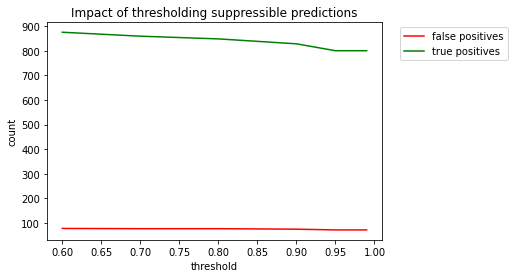

In [49]:
def pred_thres_analysis(y_proba):
    fp = np.zeros(6)
    tp = np.zeros(6)
    thresholds = [0.6,0.7,0.8,0.9,0.95,0.99]
    
    for i, thres in enumerate(thresholds):
        y_pred = np.apply_along_axis(predict_threshold, 1, y_proba, thres)
        conf_mtx = confusion_matrix(alarms_df.true_label, y_pred)
        fp[i] = conf_mtx[1][2]
        tp[i] = conf_mtx[2][2]

        print('Confusion Matrix (threshold=' + str(thres) + '):')
        print(conf_mtx)


    plt.plot(thresholds, fp, 'r', label='false positives')
    plt.plot(thresholds, tp, 'g', label='true positives')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.xlabel('threshold')
    plt.ylabel('count')
    plt.title('Impact of thresholding suppressible predictions')
    plt.show()
# end pred_thres_analysis()


pred_thres_analysis(y_proba)

In [ ]:
# n_epochs experiment

epochs_range = range(100,1001,100)
for n_epochs in epochs_range:
    l_model.fit(L_train, n_epochs=n_epochs)
    
    
plt.plot(epochs_range, y, label='majority')
plt.plot(epochs_range, y, label='0.7')
plt.plot(epochs_range, y, label='0.8')
plt.plot(epochs_range, y, label='0.9')
plt.plot(epochs_range, y, label='0.95')
plt.plot(epochs_range, y, label='0.99')
plt.legend()
plt.show()